# Import Statements

In [15]:
import OCR_pipeline as OCR
import TopicModeling as TM
import jsonpickle

# Cleaning And Saving Extracted Text

In [36]:
import mysql.connector

mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  passwd="XXX",
  database="forestry"
)

mycursor = mydb.cursor()

def getExtractedTexts():
    mycursor.execute("SELECT filename, extractedText FROM PolicyPapers")
    myresult = mycursor.fetchall()
    return [x for x in myresult]

test = "SPECIAL   ISSUE Kenya Gazette  Supplement   No.   25   (Acts No. 13)"

In [43]:
#dictionary for texts in terms of sentences
import re
import gc
textDictionary = {}
policyPapers = getExtractedTexts()
for paper in policyPapers:
    cleanWhitespaces = re.sub(r'(.) ', r'\1', paper[1])
    cleanedText = TM.toSentences(cleanWhitespaces)
    textDictionary[paper[0]] = cleanedText
   # gc.collect()

# LDA

In [44]:
from pprint import pprint
lemmatized_sents = []

# Print the Keywords in the 5 topics
for key in textDictionary:
    cleanedText = textDictionary[key]
    lemmatized_sents.extend(cleanedText)
    
corpus, lda_model = TM.LDA(lemmatized_sents)
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]
#Next Step: Store LDA data in Policy Paper Object & other central file

[(17,
  '0.139*"food" + 0.090*"agriculture" + 0.073*"production" + 0.073*"plant" + '
  '0.067*"tree" + 0.065*"distribution" + 0.065*"processing" + 0.063*"what" + '
  '0.060*"characteristic" + 0.022*"fishery"'),
 (10,
  '0.175*"land" + 0.115*"reform" + 0.068*"unit" + 0.064*"ecosystem" + '
  '0.063*"ministry" + 0.060*"programme" + 0.058*"transformation" + '
  '0.033*"sustainability" + 0.031*"establish" + 0.031*"host"'),
 (12,
  '0.230*"urban" + 0.153*"area" + 0.085*"peri" + 0.066*"refer" + 0.057*"non" + '
  '0.054*"rural" + 0.051*"boundary" + 0.043*"interface" + 0.042*"unutilized" + '
  '0.007*"population"'),
 (8,
  '0.107*"title" + 0.098*"ownership" + 0.079*"sufficient" + 0.072*"ultimate" + '
  '0.072*"radical" + 0.071*"validly" + 0.063*"refer" + 0.014*"layer" + '
  '0.009*"stock" + 0.008*"capable"'),
 (29,
  '0.103*"be" + 0.078*"biodiversity" + 0.076*"arid" + 0.074*"kshs" + '
  '0.073*"forest" + 0.061*"water" + 0.050*"area" + 0.046*"include" + '
  '0.043*"body" + 0.039*"wetland"'),
 (2

# Visualizations

### pyLDAvis

`pip install pyldavis`

Code source: https://markroxor.github.io/gensim/static/notebooks/gensim_news_classification.html
<br>
The area of the circles represent the prevalance of the topic. The length of the bars on the right represent the membership of a term in a particular topic. 

In [15]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
1      6.745592        1       1  0.329299  0.103803
21     5.794483        1       2  0.036364 -0.177803
27     4.845903        1       3  0.157184  0.017437
18     4.810839        1       4 -0.176075  0.118306
0      4.805960        1       5 -0.178741  0.110797
10     4.763830        1       6 -0.065888 -0.140362
15     3.964851        1       7  0.121288  0.043676
5      3.961241        1       8 -0.078039 -0.090604
23     3.890072        1       9 -0.112830  0.240587
3      3.700938        1      10 -0.072411 -0.038980
16     3.642051        1      11 -0.045325 -0.117298
9      3.570742        1      12  0.130345 -0.018272
2      3.525374        1      13 -0.027707 -0.099604
19     3.506183        1      14  0.257325  0.122654
14     3.270908        1      15  0.021694 -0.140731
12     3.130564        1      16 -0.014340 -0.069004
25     3.031642        1      17  0.011580 -0.029789
4      2.934283        1      18 -0.041181  0.001502
17     2.842030        1      19 -0.034844 -0.112725
7      2.776343        1      20 -0.057447 -0.034556
29     2.649990        1      21  0.004369 -0.039588
22     2.330886        1      22 -0.006981 -0.112259
11     2.313098        1      23 -0.156861  0.112812
20     2.303357        1      24  0.051818  0.141811
6      2.253207        1      25  0.088730  0.029900
8      2.183739        1      26  0.141473 -0.027353
24     2.103152        1      27 -0.072659  0.054586
26     1.851238        1      28 -0.066751  0.036719
13     1.580503        1      29 -0.053382 -0.004193
28     0.916982        1      30 -0.090005  0.118530, topic_info=     Category        Freq         Term       Total  loglift  logprob
term                                                                
930   Default  191.000000      climate  191.000000  30.0000  30.0000
566   Default  187.000000       change  187.000000  29.0000  29.0000
84    Default  121.000000       sample  121.000000  28.0000  28.0000
934   Default  156.000000    authority  156.000000  27.0000  27.0000
85    Default   76.000000         soil   76.000000  26.0000  26.0000
4     Default  547.000000           be  547.000000  25.0000  25.0000
929   Default  128.000000          act  128.000000  24.0000  24.0000
1385  Default   98.000000         land   98.000000  23.0000  23.0000
935   Default  121.000000      council  121.000000  22.0000  22.0000
217   Default   44.000000          dry   44.000000  21.0000  21.0000
487   Default   64.000000        order   64.000000  20.0000  20.0000
93    Default   53.000000       carbon   53.000000  19.0000  19.0000
960   Default   73.000000       action   73.000000  18.0000  18.0000
1600  Default   58.000000        board   58.000000  17.0000  17.0000
388   Default   69.000000       public   69.000000  16.0000  16.0000
966   Default   81.000000   government   81.000000  15.0000  15.0000
104   Default   38.000000      organic   38.000000  14.0000  14.0000
1107  Default  231.000000        shall  231.000000  13.0000  13.0000
975   Default   71.000000       county   71.000000  12.0000  12.0000
30    Default  112.000000          may  112.000000  11.0000  11.0000
955   Default   69.000000    secretary   69.000000  10.0000  10.0000
1585  Default   41.000000  agriculture   41.000000   9.0000   9.0000
1591  Default   41.000000      fishery   41.000000   8.0000   8.0000
387   Default   28.000000         mean   28.000000   7.0000   7.0000
1592  Default   36.000000         food   36.000000   6.0000   6.0000
1014  Default   41.000000  development   41.000000   5.0000   5.0000
128   Default   72.000000         such   72.000000   4.0000   4.0000
952   Default   59.000000      cabinet   59.000000   3.0000   3.0000
951   Default   60.000000       member   60.000000   2.0000   2.0000
1188  Default   42.000000  institution   42.000000   1.0000   1.0000
...       ...         ...          ...         ...   

### WordCloud

`pip install wordcloud`

Code source: https://medium.com/@rudyb2001/making-sense-of-the-news-using-machine-learning-e13ed5f96cf0
<br>
WordCloud of Top 10 words in each topic with the sizes of the words proportional to the weights.

In [16]:
len(lda_model.show_topics(formatted=False))

10

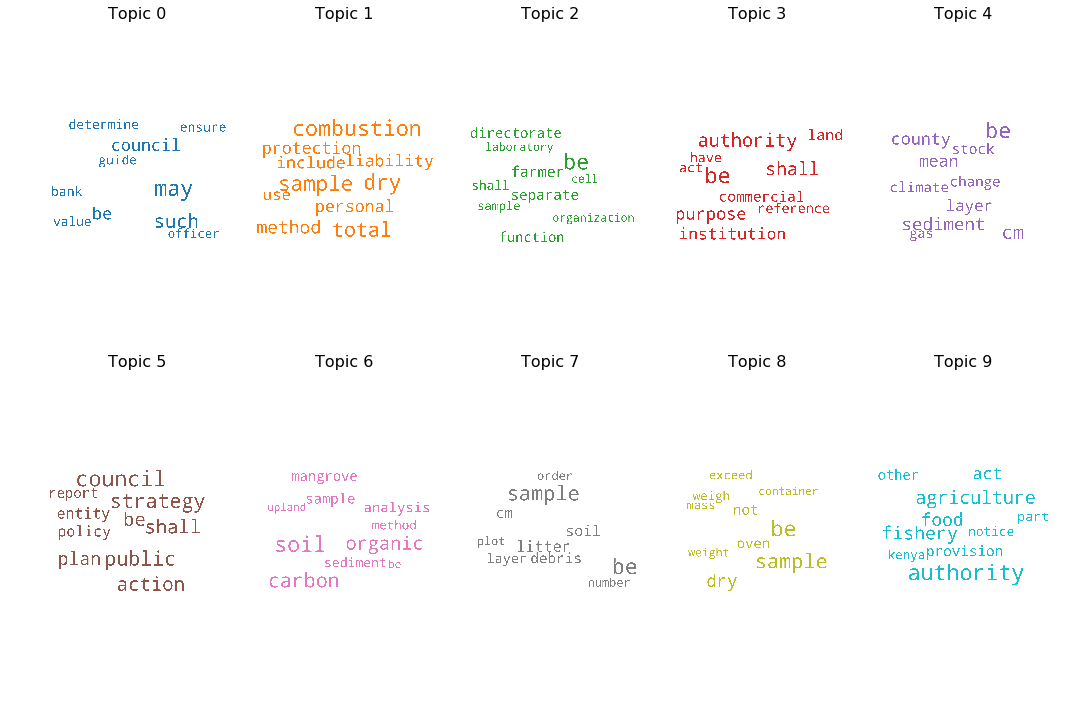

In [14]:
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(15,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Storage